In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy as cart

from datetime import timedelta as delta
from datetime import datetime

import warnings

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
from scipy.interpolate import griddata

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline

In [2]:
reload(plot)
reload(lifeline)

<module 'lifeline' from '/home/students/4302001/arctic-connectivity/tools/lifeline.py'>

In [3]:
# Specify paths to velocity field and mesh
# readdir_ocean = '/Users/daanreijnders/Datasets/'
# readdir_ice = '/Users/daanreijnders/Datasets/'
# readdir_mesh = '/Users/daanreijnders/Datasets/'

readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = ''

In [4]:
def read_velocity_field(fieldfiles, meshfile=None):
    if not meshfile:
        meshfile = fieldfiles
    filenames = {'U': {'lon': meshfile,
                       'lat': meshfile,
                       'data':fieldfiles},
                 'V': {'lon': meshfile,
                       'lat': meshfile,
                       'data':fieldfiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'},
                  'V': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'}}
    fieldset = FieldSet.from_pop(filenames, variables, dimensions, allow_time_extrapolation=False)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    
    fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1)
    fieldset.landMask = np.logical_or(fieldset.U.data[0,:,:]==-0.01, np.abs(fieldset.U.data[0,:,:])<0.0000001)
    return fieldset


# def add_ice_fields(fieldset, fieldfile, iceVars=['aice', 'hisnap', 'hi'], meshfile=None):
#     """Not working for now"""
#     if not meshfile:
#         meshfile = fieldfiles
#     for varName in iceVars:
#         filenames = {'lon': [meshfile],
#                      'lat': [meshfile],
#                      'data': [fieldfile]}
#         variable = (varName, varName)
#         dimensions = {'time': 'time',
#                       'lat': 'TLAT',
#                       'lon': 'TLON'}
#         field = Field.from_netcdf(filenames, variable, dimensions, allow_time_extrapolation=False)
#         fieldset.add_field(field)

In [5]:
# Kernels for circular boundary and for deleting particles as fallback.
def wrapLon(particle, fieldset, time):
    if particle.lon > 180.:
        particle.lon = particle.lon - 360.
    if particle.lon < -180.:
        particle.lon = particle.lon + 360.

def deleteParticle(particle, fieldset, time):
    particle.delete()

In [6]:
# Particle execution function
def gridAdvection(fieldset, \
                  countGrid, \
                  particleGrid, \
                  experiment_name='', \
                  runtime=delta(days=30), \
                  dt = delta(minutes=5), \
                  outputdt = delta(hours = 12)):
    pset = ParticleSet.from_list(fieldset, JITParticle, particleGrid.lonlat[0,:,0], particleGrid.lonlat[0,:,1])
    kernels = pset.Kernel(AdvectionRK4) + pset.Kernel(wrapLon)
    pfile = pset.ParticleFile(name = writedir+"pset_"+experiment_name, outputdt=outputdt)
    print(f"Run: Advecting particles for {runtime}")
    pset.execute(kernels, \
                 runtime = runtime, \
                 dt = dt, \
                 output_file = pfile, \
                 recovery = {ErrorCode.ErrorOutOfBounds: deleteParticle})
    return pset

In [7]:
fieldset = read_velocity_field(readdir_ocean+fieldfile_ocean, meshfile=readdir_mesh+meshfile)  

In [8]:
#add_ice_fields(fieldset, readdir_ice+fieldfile_ice, meshfile=readdir_mesh+meshfile)

In [102]:
class myGrid:
    def __init__(self, nlon, nlat, minLat=60., maxLat=90., minLon=-180, maxLon=180):
        self.nlat = nlat
        self.nlon = nlon
        self.dlat = (maxLat - minLat)/nlat
        self.dlon = 360/nlon
        
class countGrid(myGrid):
    def __init__(self, nlon, nlat, minLat=60., maxLat=90., minLon=-180, maxLon=180):
        myGrid.__init__(self, nlon, nlat, minLat, maxLat, minLon, maxLon)
        self.lonOffset = self.dlon/2
        self.latOffset = self.dlat/2
        self.lonBounds = np.linspace(minLon, maxLon, nlon+1)
        self.latBounds = np.linspace(minLat, maxLat, nlat+1)
        self.lonarr = np.linspace(minLon+self.lonOffset, maxLon-self.lonOffset, nlon) # center
        self.latarr = np.linspace(minLat+self.latOffset, maxLat-self.latOffset, nlat) # center
        self.lons, self.lats = np.meshgrid(self.lonarr, self.latarr)
        self.lonIdx, self.latIdx = np.meshgrid(np.arange(self.nlon), np.arange(self.nlat))
        self.flatIdx = np.arange(len(self.lonIdx.flatten())).reshape(self.lonIdx.shape)
        self.nIdx = len(self.lonIdx.flatten())
        
    def countInit(self, particleGrid):
        self.initCount = np.histogram2d(particleGrid.lonlat[0,:,0], particleGrid.lonlat[0,:,1], bins=[self.lonBounds, self.latBounds])[0]
        return self.initCount
    
class particleGrid(myGrid):
    def __init__(self, nlon, nlat, release_time, minLat=60.5, maxLat=89.5, minLon=-179.5, maxLon=179.5):
        myGrid.__init__(self, nlon, nlat, minLat, maxLat, minLon, maxLon)
        self.advected = False
        if release_time:
                self.release_time = release_time
        # Create mesh
        self.lonarr = np.linspace(minLon, maxLon, nlon) # particle position
        self.latarr = np.linspace(minLat, maxLat, nlat) # particle position
        self.lons, self.lats = np.meshgrid(self.lonarr, self.latarr)
        
        # Create pairs and flatten using a reshape
        self.lonlat_3d = np.dstack((self.lons, self.lats))
        self.initialParticleCount = self.countParticles()
        self.lonlat = np.array([np.reshape(self.lonlat_3d, (self.particleCount, 2))])
        
        # Create labels
        self.lonlat_labels = np.arange(self.particleCount)
        
    def countParticles(self):
        if not hasattr(self, 'lonlat') and self.advected == False:
            self.particleCount = self.lonlat_3d.shape[0]*self.lonlat_3d.shape[1]
        else:
            self.particleCount = self.lonlat.shape[1]
        return self.particleCount
    
    def remove_on_land(self, fieldset):
        # Load landmask and initialize mask for particles on land 
        lm = fieldset.landMask
        # Use scipy.interpolate.griddata to have particles adopt value of landmask from nearest neighbor
        lonlatMask = griddata(np.dstack((fieldset.U.grid.lon.flatten(), fieldset.U.grid.lat.flatten()))[0,:,:], 
                              lm.flatten(), 
                              self.lonlat[0,:,:], method='nearest')
        self.lonlat = self.lonlat[:, ~lonlatMask, :]
        self.removedParticleCount = self.countParticles()
        # recreate labels
        self.lonlat_labels = np.arange(self.particleCount)
    
    def show(self, tindex=0):
        fig = plt.figure()
        ax = plt.axes(projection=cart.crs.PlateCarree())
        ax.scatter(self.lonlat[tindex, :, 0], self.lonlat[tindex, :, 1], transform=cart.crs.PlateCarree(), s=0.2)
        ax.add_feature(cart.feature.COASTLINE)
        plt.show()
    
    def add_advected(self, pset):
        if hasattr(self, 'removedParticleCount'):
            n = self.removedParticleCount
        else:
            n = self.initialParticleCount
        newPos = np.zeros((1, n, 2))
        for idx in np.arange(n):
             newPos[0, idx, :] = [pset[idx].lon, pset[idx].lat]
        self.lonlat = np.concatenate((self.lonlat, newPos), axis=0)

class transMat:
    def __init__(self, counter):
        self.counter = counter
        self.sums = np.tile(self.counter.sum(axis=1),(self.counter.shape[1],1)).T
        self.data = np.divide(self.counter, self.sums, out=np.zeros_like(self.sums), where=self.sums!=0)

In [10]:
countG = countGrid(60, 10)
particleG = particleGrid(359, 59, 0)
particleG.remove_on_land(fieldset)

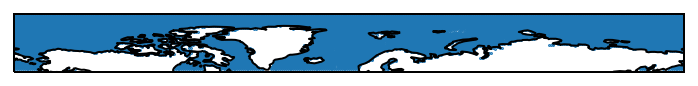

In [11]:
particleG.show()

In [12]:
# ADVECTION TAKES PLACE HERE
# psetTest = gridAdvection(fieldset, countG, particleG, experiment_name='test')

In [116]:
def createTransition(pset, countGrid, timedelta64=None):
    ds = xr.open_dataset(pset)
    timedelta64 = False
    lons = ds['lon'].data
    lats = ds['lat'].data
    ids = ds['traj'].data
    times = ds['time'].data

    if np.any(np.diff(times[:,0]).astype(bool)):
        warning.warn("Not all starting times are equal. Behaviour may not be as expected.", Warning)
    if timedelta64:
        final_tidx = np.searchsorted(times[0,:], times[0,0]+timedelta64)
        if final_tidx == times.shape[1]:
            warning.warn("`final_tidx` lies outside of time window. Choosing last index instead", Warning)
            final_tidx = times.shape[1]-1
    else:
        final_tidx = times.shape[1]-1
    lonlat_init = np.dstack((lons[:,0], lats[:,0]))
    lonlat_final = np.dstack((lons[:,final_tidx], lats[:, final_tidx]))

    bindex_init = np.dstack((np.searchsorted(countGrid.lonBounds, lonlat_init[0,:,0]), np.searchsorted(countGrid.latBounds, lonlat_init[0,:,1])))[0]-1
    bindex_final = np.dstack((np.searchsorted(countGrid.lonBounds, lonlat_final[0,:,0]), np.searchsorted(countGrid.latBounds, lonlat_final[0,:,1])))[0]-1
    """2 issues:
    lonlats with NaN values will be put at index 60, 30 respectively. For these we don't want to look up the bindex
    """
    ds.close()

    counter = np.zeros((countGrid.nIdx, countGrid.nIdx))
    N = bindex_init.shape[0]
    for i in range(N):
        print (f"\r Determining particle bins. {np.ceil(i/(N-1)*100)}%", end="")
        if (    bindex_final[i,0] < countGrid.flatIdx.shape[1] - 1
            and bindex_final[i,0] >= 0
            and bindex_final[i,1] < countGrid.flatIdx.shape[0]
            and bindex_final[i,1] >= 0): # moved outside domain
            sourceIdx = countGrid.flatIdx[bindex_init[i,1], bindex_init[i,0]]
            destIdx = countGrid.flatIdx[bindex_final[i,1], bindex_final[i,0]]
            counter[sourceIdx, destIdx] += 1
    return transMat(counter)

In [117]:
mytransmat = createTransition('pset_test.nc', countG)

 Determining particle bins. 100.0%

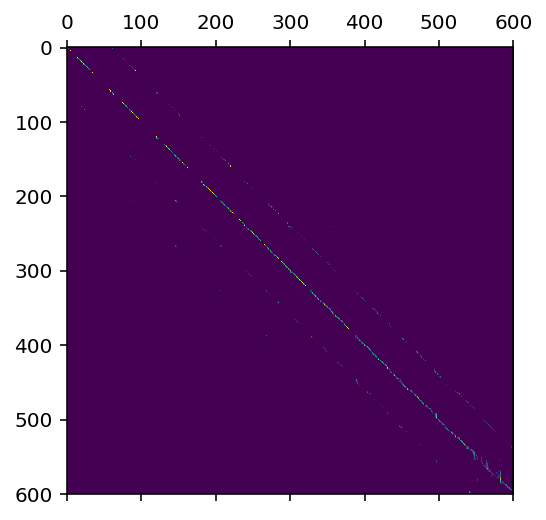

In [118]:
plt.matshow(mytransmat.data)